In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (confusion_matrix, roc_auc_score, 
                            precision_recall_curve, auc)
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from numpy import sqrt, errstate, isfinite

In [18]:
def load_and_preprocess(debug=False):
    # Load datasets
    interactions = pd.read_csv("Interactions.csv")
    human_embeds = pd.read_csv("drop_Human_BiLSTM_Final_Embeddings.csv")
    dengue_embeds = pd.read_csv("drop_Dengue_BiLSTM_Final_Embeddings.csv")

    if debug:
        print("=== Original Interactions ===")
        display(interactions.head(2))
        print("\n=== Human Embeddings ===")
        display(human_embeds.head(2))
        print("\n=== Dengue Embeddings ===")
        display(dengue_embeds.head(2))

    # Remove duplicate embeddings
    human_embeds = human_embeds.drop_duplicates(subset=['Protein_Sequence'])
    dengue_embeds = dengue_embeds.drop_duplicates(subset=['Dengue_Sequence'])

    # First merge - Human embeddings
    merged = interactions.merge(
        human_embeds,
        left_on="Human Sequence",
        right_on="Protein_Sequence",
        how="left"
    )
    
    if debug:
        print("\n=== After Human Embeddings Merge ===")
        print(f"Merged shape: {merged.shape}")
        print("Columns:", merged.columns.tolist())
        display(merged[['Human Protein', 'Human Sequence', 'Protein_Sequence'] + 
                      [c for c in merged.columns if 'Dim_' in c]].head(2))
        
        # Check merge success
        human_missing = merged['Protein_Sequence'].isna().sum()
        print(f"\nHuman sequences without embeddings: {human_missing}/{len(merged)}")

    # Second merge - Dengue embeddings
    merged = merged.merge(
        dengue_embeds,
        left_on="Dengue Sequence",
        right_on="Dengue_Sequence",
        how="left",
        suffixes=("_human", "_dengue")
    )
    
    if debug:
        print("\n=== After Dengue Embeddings Merge ===")
        print(f"Final merged shape: {merged.shape}")
        print("Columns:", merged.columns.tolist())
        display(merged[['Dengue Protein', 'Dengue Sequence', 'Dengue_Sequence'] + 
                      [c for c in merged.columns if 'Dim_' in c]].head(2))
        
        # Check merge success
        dengue_missing = merged['Dengue_Sequence'].isna().sum()
        print(f"Dengue sequences without embeddings: {dengue_missing}/{len(merged)}")

    # Cleanup
    merged = merged.drop(columns=['Protein_Sequence', 'Dengue_Sequence'])
    
    if debug:
        print("\n=== Final Columns After Cleanup ===")
        print(merged.columns.tolist())

    # Filter features and labels
    features = [c for c in merged.columns if 'Dim_' in c] + ['Label']
    return merged[features]

# Run with debugging
data = load_and_preprocess(debug=True)


=== Original Interactions ===


,Human Protein,Human Sequence,Dengue Protein,Dengue Sequence,Label
0,WWP1,XGGPQIAYERGFRWKLAHFRYLCQSNALPSHVKINVSRQTLFEDSF...,NP_739583.2_Envelope_DV2,MRCIGMSNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELI...,1
1,UBE2I,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,NP_739586.2_NS2B_DV2,SWPLNEAIMAVGMVSILASSLLKNDIPMTGPLVAGGLLTVCYVLTG...,1



=== Human Embeddings ===


,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8,Dim_9,...,Dim_119,Dim_120,Dim_121,Dim_122,Dim_123,Dim_124,Dim_125,Dim_126,Dim_127,Protein_Sequence
0,0.100120,0.143917,0.069306,0.190419,0.146801,0.082436,0.204884,0.143696,0.043883,0.108749,...,0.0,0.118396,0.135560,0.127732,0.117165,0.138740,0.123951,0.127625,0.172154,XGGPQIAYERGFRWKLAHFRYLCQSNALPSHVKINVSRQTLFEDSF...
1,0.137317,0.180786,0.099678,0.142546,0.169574,0.186774,0.222408,0.118245,0.029202,0.159771,...,0.0,0.115852,0.155566,0.135313,0.089919,0.165655,0.177666,0.110808,0.131533,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...



=== Dengue Embeddings ===


,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8,Dim_9,...,Dim_119,Dim_120,Dim_121,Dim_122,Dim_123,Dim_124,Dim_125,Dim_126,Dim_127,Dengue_Sequence
0,0.136124,0.080187,0.124397,0.295037,0.081511,0.132528,0.045180,0.214676,0.100824,0.068248,...,0.12381,0.03535,0.176628,0.141085,0.198717,0.143959,0.113815,0.150970,0.100107,MRCIGMSNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELI...
1,0.074011,0.119052,0.106164,0.052359,0.052547,0.100648,0.135321,0.099151,0.102827,0.163830,...,0.14251,0.10285,0.065761,0.132342,0.178200,0.058467,0.180802,0.074464,0.111978,SWPLNEAIMAVGMVSILASSLLKNDIPMTGPLVAGGLLTVCYVLTG...



=== After Human Embeddings Merge ===
Merged shape: (1303, 134)
Columns: ['Human Protein', 'Human Sequence', 'Dengue Protein', 'Dengue Sequence', 'Label', 'Dim_0', 'Dim_1', 'Dim_2', 'Dim_3', 'Dim_4', 'Dim_5', 'Dim_6', 'Dim_7', 'Dim_8', 'Dim_9', 'Dim_10', 'Dim_11', 'Dim_12', 'Dim_13', 'Dim_14', 'Dim_15', 'Dim_16', 'Dim_17', 'Dim_18', 'Dim_19', 'Dim_20', 'Dim_21', 'Dim_22', 'Dim_23', 'Dim_24', 'Dim_25', 'Dim_26', 'Dim_27', 'Dim_28', 'Dim_29', 'Dim_30', 'Dim_31', 'Dim_32', 'Dim_33', 'Dim_34', 'Dim_35', 'Dim_36', 'Dim_37', 'Dim_38', 'Dim_39', 'Dim_40', 'Dim_41', 'Dim_42', 'Dim_43', 'Dim_44', 'Dim_45', 'Dim_46', 'Dim_47', 'Dim_48', 'Dim_49', 'Dim_50', 'Dim_51', 'Dim_52', 'Dim_53', 'Dim_54', 'Dim_55', 'Dim_56', 'Dim_57', 'Dim_58', 'Dim_59', 'Dim_60', 'Dim_61', 'Dim_62', 'Dim_63', 'Dim_64', 'Dim_65', 'Dim_66', 'Dim_67', 'Dim_68', 'Dim_69', 'Dim_70', 'Dim_71', 'Dim_72', 'Dim_73', 'Dim_74', 'Dim_75', 'Dim_76', 'Dim_77', 'Dim_78', 'Dim_79', 'Dim_80', 'Dim_81', 'Dim_82', 'Dim_83', 'Dim_84', 'Dim_

,Human Protein,Human Sequence,Protein_Sequence,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,...,Dim_118,Dim_119,Dim_120,Dim_121,Dim_122,Dim_123,Dim_124,Dim_125,Dim_126,Dim_127
0,WWP1,XGGPQIAYERGFRWKLAHFRYLCQSNALPSHVKINVSRQTLFEDSF...,XGGPQIAYERGFRWKLAHFRYLCQSNALPSHVKINVSRQTLFEDSF...,0.100120,0.143917,0.069306,0.190419,0.146801,0.082436,0.204884,...,0.082820,0.0,0.118396,0.135560,0.127732,0.117165,0.138740,0.123951,0.127625,0.172154
1,UBE2I,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...,0.137317,0.180786,0.099678,0.142546,0.169574,0.186774,0.222408,...,0.064518,0.0,0.115852,0.155566,0.135313,0.089919,0.165655,0.177666,0.110808,0.131533



Human sequences without embeddings: 0/1303

=== After Dengue Embeddings Merge ===
Final merged shape: (1303, 263)
Columns: ['Human Protein', 'Human Sequence', 'Dengue Protein', 'Dengue Sequence', 'Label', 'Dim_0_human', 'Dim_1_human', 'Dim_2_human', 'Dim_3_human', 'Dim_4_human', 'Dim_5_human', 'Dim_6_human', 'Dim_7_human', 'Dim_8_human', 'Dim_9_human', 'Dim_10_human', 'Dim_11_human', 'Dim_12_human', 'Dim_13_human', 'Dim_14_human', 'Dim_15_human', 'Dim_16_human', 'Dim_17_human', 'Dim_18_human', 'Dim_19_human', 'Dim_20_human', 'Dim_21_human', 'Dim_22_human', 'Dim_23_human', 'Dim_24_human', 'Dim_25_human', 'Dim_26_human', 'Dim_27_human', 'Dim_28_human', 'Dim_29_human', 'Dim_30_human', 'Dim_31_human', 'Dim_32_human', 'Dim_33_human', 'Dim_34_human', 'Dim_35_human', 'Dim_36_human', 'Dim_37_human', 'Dim_38_human', 'Dim_39_human', 'Dim_40_human', 'Dim_41_human', 'Dim_42_human', 'Dim_43_human', 'Dim_44_human', 'Dim_45_human', 'Dim_46_human', 'Dim_47_human', 'Dim_48_human', 'Dim_49_human', 'Dim

,Dengue Protein,Dengue Sequence,Dengue_Sequence,Dim_0_human,Dim_1_human,Dim_2_human,Dim_3_human,Dim_4_human,Dim_5_human,Dim_6_human,...,Dim_118_dengue,Dim_119_dengue,Dim_120_dengue,Dim_121_dengue,Dim_122_dengue,Dim_123_dengue,Dim_124_dengue,Dim_125_dengue,Dim_126_dengue,Dim_127_dengue
0,NP_739583.2_Envelope_DV2,MRCIGMSNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELI...,MRCIGMSNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELI...,0.100120,0.143917,0.069306,0.190419,0.146801,0.082436,0.204884,...,0.182152,0.12381,0.03535,0.176628,0.141085,0.198717,0.143959,0.113815,0.150970,0.100107
1,NP_739586.2_NS2B_DV2,SWPLNEAIMAVGMVSILASSLLKNDIPMTGPLVAGGLLTVCYVLTG...,SWPLNEAIMAVGMVSILASSLLKNDIPMTGPLVAGGLLTVCYVLTG...,0.137317,0.180786,0.099678,0.142546,0.169574,0.186774,0.222408,...,0.127008,0.14251,0.10285,0.065761,0.132342,0.178200,0.058467,0.180802,0.074464,0.111978


Dengue sequences without embeddings: 0/1303

=== Final Columns After Cleanup ===
['Human Protein', 'Human Sequence', 'Dengue Protein', 'Dengue Sequence', 'Label', 'Dim_0_human', 'Dim_1_human', 'Dim_2_human', 'Dim_3_human', 'Dim_4_human', 'Dim_5_human', 'Dim_6_human', 'Dim_7_human', 'Dim_8_human', 'Dim_9_human', 'Dim_10_human', 'Dim_11_human', 'Dim_12_human', 'Dim_13_human', 'Dim_14_human', 'Dim_15_human', 'Dim_16_human', 'Dim_17_human', 'Dim_18_human', 'Dim_19_human', 'Dim_20_human', 'Dim_21_human', 'Dim_22_human', 'Dim_23_human', 'Dim_24_human', 'Dim_25_human', 'Dim_26_human', 'Dim_27_human', 'Dim_28_human', 'Dim_29_human', 'Dim_30_human', 'Dim_31_human', 'Dim_32_human', 'Dim_33_human', 'Dim_34_human', 'Dim_35_human', 'Dim_36_human', 'Dim_37_human', 'Dim_38_human', 'Dim_39_human', 'Dim_40_human', 'Dim_41_human', 'Dim_42_human', 'Dim_43_human', 'Dim_44_human', 'Dim_45_human', 'Dim_46_human', 'Dim_47_human', 'Dim_48_human', 'Dim_49_human', 'Dim_50_human', 'Dim_51_human', 'Dim_52_human',

In [19]:
def create_balanced_data(df):
    X = df.drop(columns=['Label'])
    y = df['Label']
    
    # Balance classes
    majority = df[df.Label == 0]
    minority = df[df.Label == 1]
    
    minority_upsampled = resample(minority,
                                 replace=True,
                                 n_samples=len(majority),
                                 random_state=42)
    
    balanced = pd.concat([majority, minority_upsampled])
    return balanced.drop(columns=['Label']), balanced['Label']

X, y = create_balanced_data(data)

In [20]:
def print_distribution(y_data, name):
    """Print class distribution statistics"""
    unique, counts = np.unique(y_data, return_counts=True)
    print(f"\n{name} Set (n={len(y_data)})")
    print(f"Positive: {counts[1]} ({counts[1]/len(y_data):.1%})")
    print(f"Negative: {counts[0]} ({counts[0]/len(y_data):.1%})")

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [22]:
print_distribution(y_train, "Training")
print_distribution(y_test, "Testing")


Training Set (n=1105)
Positive: 553 (50.0%)
Negative: 552 (50.0%)

Testing Set (n=277)
Positive: 138 (49.8%)
Negative: 139 (50.2%)


In [23]:
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(X_train.shape[1])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 299,009 (1.14 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [28]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9913 - loss: 0.0188 - val_accuracy: 0.8448 - val_loss: 0.6416
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0134 - val_accuracy: 0.8159 - val_loss: 0.9500
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.8267 - val_loss: 0.7441
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9964 - loss: 0.0137 - val_accuracy: 0.8087 - val_loss: 0.7264
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9966 - loss: 0.0122 - val_accuracy: 0.8339 - val_loss: 0.6716
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9933 - loss: 0.0186 - val_accuracy: 0.8087 - val_loss: 0.7084
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.8303 - val_loss: 0.6888
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9934 - loss: 0.0244 - val_accuracy: 0.7870 -

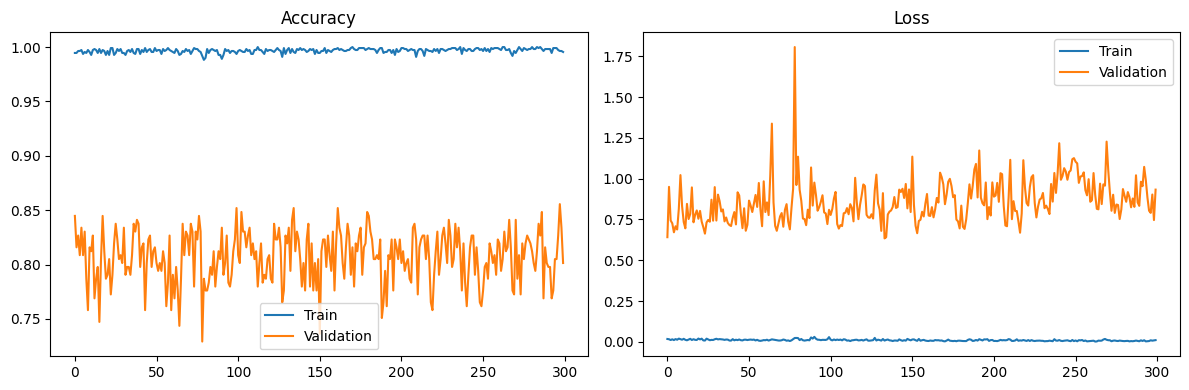

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [30]:
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X).ravel()
    y_pred_class = (y_pred > 0.5).astype(int)
    
    # Handle single-class predictions
    if len(np.unique(y_pred_class)) == 1:
        print(f"All predictions same class in {set_name}")
        return {
            "Accuracy": np.nan,
            "AUC": np.nan,
            "AUPRC": np.nan
        }
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred_class).ravel()
    
    # Calculate metrics
    metrics = {
        "Accuracy": (tp + tn) / len(y),
        "Sensitivity": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
        "AUC": roc_auc_score(y, y_pred),
    }
    
    # Calculate AUPRC safely
    precision, recall, _ = precision_recall_curve(y, y_pred)
    recall, precision = zip(*sorted(zip(recall, precision)))
    metrics["AUPRC"] = auc(recall, precision)
    
    print(f"\n{set_name} Metrics:")
    for k, v in metrics.items():
        print(f"{k:12}: {v:.4f}")
    
    return metrics

best_model = load_model('best_model.keras')

print("=== Final Evaluation ===")
train_metrics = evaluate_model(best_model, X_train, y_train, "Training")
test_metrics = evaluate_model(best_model, X_test, y_test, "Testing")

=== Final Evaluation ===
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Training Metrics:
Accuracy    : 1.0000
Sensitivity : 1.0000
Specificity : 1.0000
AUC         : 1.0000
AUPRC       : 0.9991
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Testing Metrics:
Accuracy    : 0.8412
Sensitivity : 0.8551
Specificity : 0.8273
AUC         : 0.9241
AUPRC       : 0.9327


In [32]:
# Save final model
model.save("fc_final_model.keras")
print("Model saved successfully")

Model saved successfully
